In [40]:
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END, START
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import operator
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
import os
import dotenv

In [14]:
dotenv.load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [15]:

llm = ChatGroq(model = "llama-3.3-70b-versatile",verbose=True,max_tokens=500,api_key=GROQ_API_KEY)

In [17]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [18]:
web_search_tool = TavilySearchResults(max_results=3)

In [26]:
from langchain_classic.document_loaders import PyPDFLoader
pdf = PyPDFLoader("NIPS-2017-attention-is-all-you-need-Paper.pdf")
docs = pdf.load()
docs

[Document(metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existing best ensemble result by over 1 BLEU. On 

In [27]:
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 100)

split_docs = splitter.split_documents(docs)
split_docs

[Document(metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existing best ensemble result by over 1 BLEU. On 

In [29]:
from langchain_classic.vectorstores import FAISS,faiss
vectorstore = FAISS.from_documents(split_docs,embeddings)
retriever = vectorstore.as_retriever()


In [30]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    query: str
    generation: str
    documents: List[Document]
    search_performed: bool
    useful: bool


In [43]:
def query_analysis(state: GraphState) -> GraphState:
    """
    Analyze the query to determine if it needs web search or vector retrieval.
    The vector store contains information about a scientific paper called as attention is all you need.
    """
    query = state["query"]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a query analyzer. Determine if this query requires:
        - 'websearch': Real-time information, current events, recent data
        - 'vectorstore': General knowledge, historical information, stored documents
        
        Respond with ONLY 'websearch' or 'vectorstore'."""),
        ("human", "{query}")
    ])
    
    chain = prompt | llm | StrOutputParser()
    decision = chain.invoke({"query": query}).strip().lower()
    
    state["search_performed"] = "websearch" in decision
    return state


In [44]:
def web_search(state: GraphState) -> GraphState:
    """
    Perform web search for current information.
    """
    query = state["query"]
    print(f"→ Performing web search for: {query}")
    
    search_results = web_search_tool.invoke(query)
    documents = [
        Document(page_content=result["content"], metadata={"source": result.get("url", "web")})
        for result in search_results
    ]
    
    state["documents"] = documents
    return state

In [45]:
def retrieve(state: GraphState) -> GraphState:
    """
    Retrieve documents from vector store.
    """
    query = state["query"]
    print(f"→ Retrieving documents for: {query}")
    
    documents = retriever.invoke(query)
    state["documents"] = documents
    return state

In [46]:
def grade_documents(state: GraphState) -> GraphState:
    """
    Grade the relevance of retrieved documents.
    """
    query = state["query"]
    documents = state["documents"]
    
    print(f"→ Grading {len(documents)} documents")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a document grader. Determine if the document is relevant to the query.
        Respond with ONLY 'yes' or 'no'."""),
        ("human", "Query: {query}\n\nDocument: {document}\n\nIs this document relevant?")
    ])
    
    chain = prompt | llm | StrOutputParser()
    
    filtered_docs = []
    for doc in documents:
        grade = chain.invoke({
            "query": query,
            "document": doc.page_content
        }).strip().lower()
        
        if "yes" in grade:
            filtered_docs.append(doc)
    
    print(f"→ {len(filtered_docs)}/{len(documents)} documents passed grading")
    if not filtered_docs and not state.get("search_performed"):
        state["documents"] = []
        state["useful"] = False
    else:
        state["documents"] = filtered_docs
        state["useful"] = len(filtered_docs) > 0
    
    return state



In [47]:
def transform_query(state: GraphState) -> GraphState:
    """
    Transform the query to improve retrieval.
    """
    query = state["query"]
    print(f"→ Transforming query: {query}")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a query rewriter. Rewrite the query to be more specific and 
        retrieval-friendly. Make it clearer and more detailed while maintaining the core intent.
        Return ONLY the rewritten query."""),
        ("human", "{query}")
    ])
    
    chain = prompt | llm | StrOutputParser()
    transformed_query = chain.invoke({"query": query})
    
    print(f"→ Transformed to: {transformed_query}")
    state["query"] = transformed_query
    return state

In [48]:
def generate(state: GraphState) -> GraphState:
    """
    Generate answer based on retrieved documents.
    """
    query = state["query"]
    documents = state["documents"]
    
    print(f"→ Generating answer")
    
    context = "\n\n".join([doc.page_content for doc in documents])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an AI assistant. Answer the question based on the provided context.
        If the context doesn't contain relevant information, say so clearly.
        Be concise and accurate."""),
        ("human", "Context:\n{context}\n\nQuestion: {query}\n\nAnswer:")
    ])
    
    chain = prompt | llm | StrOutputParser()
    generation = chain.invoke({"context": context, "query": query})
    
    state["generation"] = generation
    return state

In [49]:
def route_after_query_analysis(state: GraphState) -> str:
    """
    Route to web search or vector retrieval based on query analysis.
    """
    if state.get("search_performed"):
        return "web_search"
    return "retrieve"

In [50]:
def route_after_grading(state: GraphState) -> str:
    """
    Route based on document grading results.
    """
    if state.get("useful"):
        return "generate"
    elif not state.get("search_performed"):
        return "transform_query"
    else:
        return "generate"

In [51]:
def route_after_transform(state: GraphState) -> str:
    """
    Route to web search after query transformation.
    """
    return "web_search"

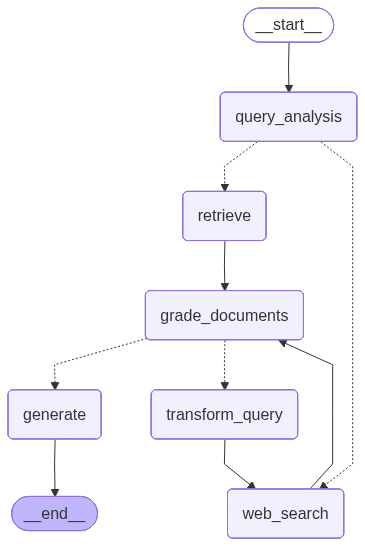

In [52]:
from IPython.display import display,Image 
workflow = StateGraph(GraphState)

workflow.add_node("query_analysis", query_analysis)
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)

workflow.add_edge(START,"query_analysis")
workflow.add_conditional_edges(
    "query_analysis",
    route_after_query_analysis,
    {
        "web_search": "web_search",
        "retrieve": "retrieve"
    }
)
workflow.add_edge("web_search", "grade_documents")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    route_after_grading,
    {
        "generate": "generate",
        "transform_query": "transform_query"
    }
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("generate", END)
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [53]:
def run_rag_system(query: str) -> dict:
    """
    Run the adaptive RAG system with a query.
    """
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"{'='*60}\n")
    
    initial_state = {
        "query": query,
        "generation": "",
        "documents": [],
        "search_performed": False,
        "useful": False
    }
    
    result = app.invoke(initial_state)
    
    print(f"\n{'='*60}")
    print(f"Final Answer:")
    print(f"{'='*60}")
    print(result["generation"])
    print(f"\n{'='*60}\n")
    
    return result

In [55]:
query = "How can attention mechanism help in transformers"
print(run_rag_system(query))


Query: How can attention mechanism help in transformers

→ Retrieving documents for: How can attention mechanism help in transformers
→ Grading 4 documents
→ 4/4 documents passed grading
→ Generating answer

Final Answer:
The attention mechanism in transformers helps by allowing the model to attend to all positions in the input sequence simultaneously and weigh their importance, enabling it to model dependencies without regard to their distance in the input or output sequences. This is particularly useful in sequence modeling and transduction tasks.


{'query': 'How can attention mechanism help in transformers', 'generation': 'The attention mechanism in transformers helps by allowing the model to attend to all positions in the input sequence simultaneously and weigh their importance, enabling it to model dependencies without regard to their distance in the input or output sequences. This is particularly useful in sequence modeling and transduction tasks.', 'documents': [Document(id='3